In [2]:
import anndata as ad
import pandas as pd
import numpy as np
import numba
import matplotlib.pyplot as plt
import torch
import timeit

In [3]:
data = ad.read_h5ad('common/common/openproblems_bmmc_multiome_phase1v2/openproblems_bmmc_multiome_phase1v2.manual_formatting.output_rna.h5ad')

# Size factor normalization

In [4]:
size_factors = data.obs['size_factors'].to_numpy()[:, np.newaxis]
X = data.X.toarray()

# Transfer to GPU
size_factors_cuda = torch.Tensor(size_factors).cuda()
X_cuda = torch.Tensor(X).cuda()

In [5]:
def correct_size_factors(X, size_factors):
    return X * size_factors

@numba.jit(nopython=True)
def correct_size_factors_numba(X, size_factors):
    return X * size_factors

# compile
correct_size_factors_numba(X, size_factors)

array([[0.        , 0.        , 0.        , ..., 0.76561933, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.20788933, 0.        ,
        0.        ],
       [0.83782929, 0.        , 0.        , ..., 3.54369745, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [6]:
def benchmark_normalization(target_function, X, size_factors, n_to_try: list, tries=3):
    result_mean = []
    result_std = []
    for n in n_to_try:
        print(f'Benchmarking with {n}x{n}...')
        
        if isinstance(X, torch.Tensor):
            X_sub = X[:n, :n].clone()
            size_factors_sub = size_factors[:n, :].clone()
        else:
            X_sub = X[:n, :n].copy()
            size_factors_sub = size_factors[:n, :].copy()

        current_tries = []
        for _ in range(tries):
            start = timeit.default_timer()
            target_function(X_sub, size_factors_sub)
            delta_time = timeit.default_timer() - start
            current_tries.append(delta_time)
        result_mean.append(np.mean(current_tries))
        result_std.append(np.std(current_tries))
    return result_mean, result_std

In [7]:
n_to_try = [10, 100, 1000, 5000, 10000, 30000, X.shape[0]]

print('Benchmarking plain python')
plain_python = benchmark_normalization(correct_size_factors, X, size_factors, n_to_try)
print()

print('Benchmarking numba compiled')
compiled_numba = benchmark_normalization(correct_size_factors_numba, X, size_factors, n_to_try)
print()

print('Benchmarking cuda')
cuda = benchmark_normalization(correct_size_factors, X_cuda, size_factors_cuda, n_to_try)
print()

Benchmarking plain python
Benchmarking with 10x10...
Benchmarking with 100x100...
Benchmarking with 1000x1000...
Benchmarking with 5000x5000...
Benchmarking with 10000x10000...
Benchmarking with 30000x30000...
Benchmarking with 42492x42492...

Benchmarking numba compiled
Benchmarking with 10x10...
Benchmarking with 100x100...
Benchmarking with 1000x1000...
Benchmarking with 5000x5000...
Benchmarking with 10000x10000...
Benchmarking with 30000x30000...
Benchmarking with 42492x42492...

Benchmarking cuda
Benchmarking with 10x10...
Benchmarking with 100x100...
Benchmarking with 1000x1000...
Benchmarking with 5000x5000...
Benchmarking with 10000x10000...
Benchmarking with 30000x30000...
Benchmarking with 42492x42492...



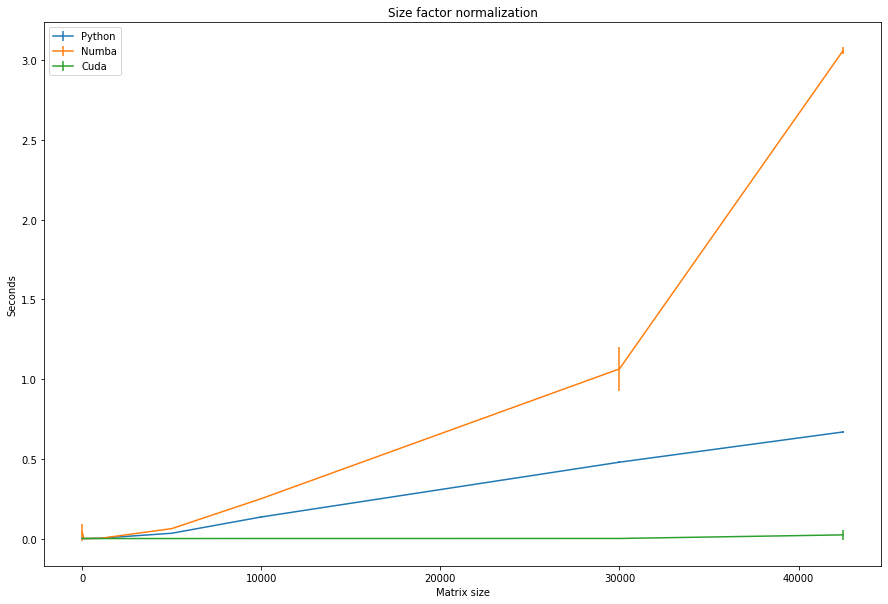

In [8]:
plt.figure(figsize=(15, 10))
plt.errorbar(n_to_try, plain_python[0], yerr=plain_python[1], label='Python')
plt.errorbar(n_to_try, compiled_numba[0], yerr=compiled_numba[1], label='Numba')
plt.errorbar(n_to_try, cuda[0], yerr=cuda[1], label='Cuda')
plt.title('Size factor normalization')
plt.xlabel('Matrix size')
plt.ylabel('Seconds')
plt.legend()


In [9]:
del X
del X_cuda
del size_factors
del size_factors_cuda

# Calculation of mitochondrial genes fraction

In [10]:
genes = data.var.index.to_list()
is_mito = []
for gene in genes:
    if gene.startswith('MT'):
        is_mito.append(True)
    else:
        is_mito.append(False)
is_mito = np.array(is_mito)
counts = data.layers['counts'].toarray()

In [11]:
# Transfer to GPU
counts_cuda = torch.Tensor(counts).cuda()
is_mito_cuda = torch.Tensor(is_mito).to(torch.bool).cuda()

In [17]:
def calculate_mito_fraction(counts, is_mito):
    total_mito_counts = counts[:, is_mito].sum(axis=1)
    total_counts = counts.sum(axis=1)
    return total_mito_counts / total_counts

@numba.jit(nopython=True, parallel=True)
def calculate_mito_fraction_numba(counts, is_mito):
    total_mito_counts = counts[:, is_mito].sum(axis=1)
    total_counts = counts.sum(axis=1)
    return total_mito_counts / total_counts

# compile
calculate_mito_fraction_numba(counts, is_mito)

array([0.01420839, 0.01410178, 0.00896861, ..., 0.00279525, 0.00216294,
       0.00408441])

In [18]:
def benchmark_mito(target_function, counts, is_mito, n_to_try: list, tries=3):
    result_mean = []
    result_std = []
    for n in n_to_try:
        print(f'Benchmarking with {n}x{n}...')
        
        if isinstance(counts, torch.Tensor):
            counts_sub = counts[:n, :n].clone()
            is_mito_sub = is_mito[:n].clone()
        else:
            counts_sub = counts[:n, :n].copy()
            is_mito_sub = is_mito[:n].copy()

        current_tries = []
        for _ in range(tries):
            start = timeit.default_timer()
            target_function(counts_sub, is_mito_sub)
            delta_time = timeit.default_timer() - start
            current_tries.append(delta_time)
        result_mean.append(np.mean(current_tries))
        result_std.append(np.std(current_tries))
    return result_mean, result_std

In [19]:
n_to_try = [10, 100, 1000, 5000, 10000, 30000, counts.shape[0]]

print('Benchmarking plain python')
plain_python = benchmark_mito(calculate_mito_fraction, counts, is_mito, n_to_try)
print()

print('Benchmarking numba compiled')
compiled_numba = benchmark_mito(calculate_mito_fraction_numba, counts, is_mito, n_to_try)
print()

print('Benchmarking cuda')
cuda = benchmark_mito(calculate_mito_fraction, counts_cuda, is_mito_cuda, n_to_try)
print()

Benchmarking plain python
Benchmarking with 10x10...
Benchmarking with 100x100...
Benchmarking with 1000x1000...
Benchmarking with 5000x5000...


/tmp/ipykernel_35916/1383894042.py:4: RuntimeWarning: invalid value encountered in true_divide
  return total_mito_counts / total_counts


Benchmarking with 10000x10000...
Benchmarking with 30000x30000...
Benchmarking with 42492x42492...

Benchmarking numba compiled
Benchmarking with 10x10...
Benchmarking with 100x100...
Benchmarking with 1000x1000...
Benchmarking with 5000x5000...
Benchmarking with 10000x10000...
Benchmarking with 30000x30000...
Benchmarking with 42492x42492...

Benchmarking cuda
Benchmarking with 10x10...
Benchmarking with 100x100...
Benchmarking with 1000x1000...
Benchmarking with 5000x5000...
Benchmarking with 10000x10000...
Benchmarking with 30000x30000...
Benchmarking with 42492x42492...



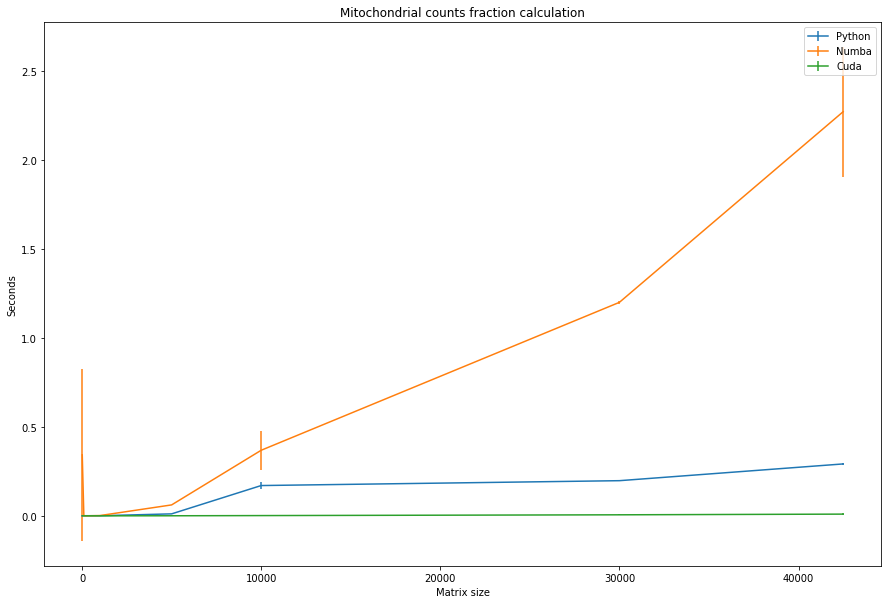

In [20]:
plt.figure(figsize=(15, 10))
plt.errorbar(n_to_try, plain_python[0], yerr=plain_python[1], label='Python')
plt.errorbar(n_to_try, compiled_numba[0], yerr=compiled_numba[1], label='Numba')
plt.errorbar(n_to_try, cuda[0], yerr=cuda[1], label='Cuda')
plt.title('Mitochondrial counts fraction calculation')
plt.xlabel('Matrix size')
plt.ylabel('Seconds')
plt.legend()
